# Домашняя работа - модели ARIMA и GARCH, прогнозирование значений на их основе

ДАНИЛЬЧЕНКО ВАДИМ

ЗАДАНИЕ:

- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

-------------------------------------------------------------------------------------------------------------------------------

In [19]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [242]:
# возмем среднемесячные показатели температуры

series=pd.read_csv("data/Series/mean-monthly-air-temperature-deg.csv").iloc[:,-1]
series.head()

0    40.6
1    40.8
2    44.4
3    46.7
4    54.1
Name: Deg, dtype: float64

### ARIMA 

In [187]:
# функция возвращает значения статистик для теста Дики-Фуллера

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [188]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [189]:
# построим модель ARIMA, отобразим статистику теста на стационарность ряда и отобразим график временного ряда, модели и др

best_aic = np.inf 
best_order = None
best_mdl = None

for i in tqdm_notebook(range(5)):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 1149.82449 | order: (2, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -5.576108
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


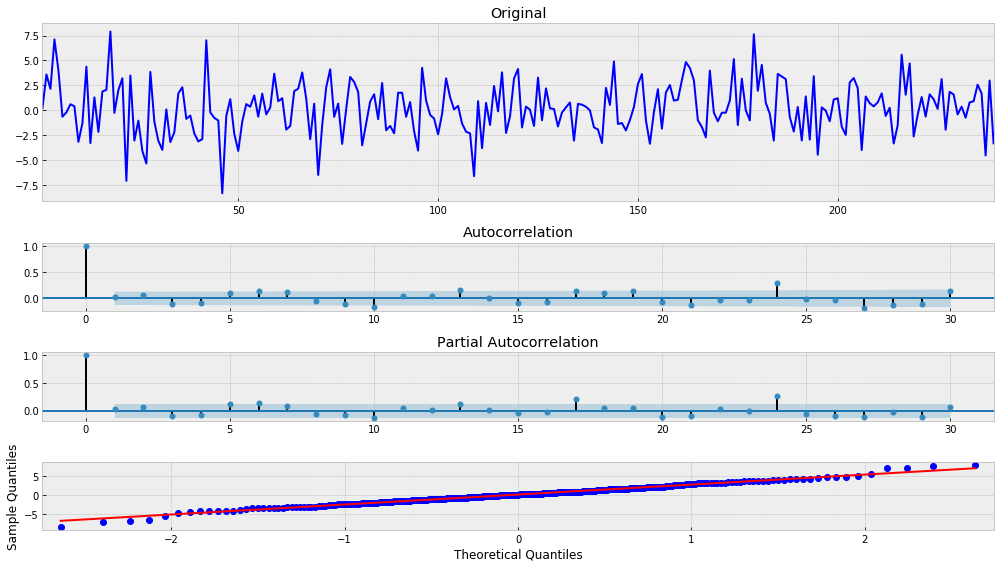

In [190]:
tsplot(best_mdl.resid, lags=30)

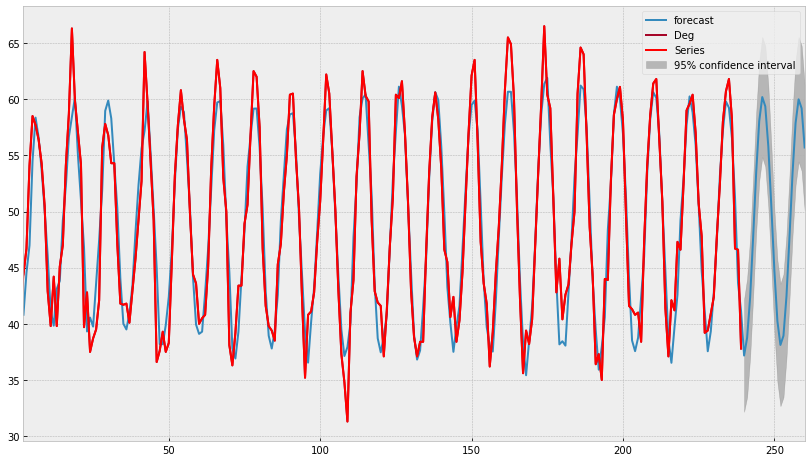

In [191]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

очень хорошо подогнанная на вид модель, и остатки стационарны и прогноз кажется вполне логичным

### GARCH 

In [194]:
# ! pip install arch
from arch import arch_model

In [195]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: 1149.82449 | order: (2, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -5.576108
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


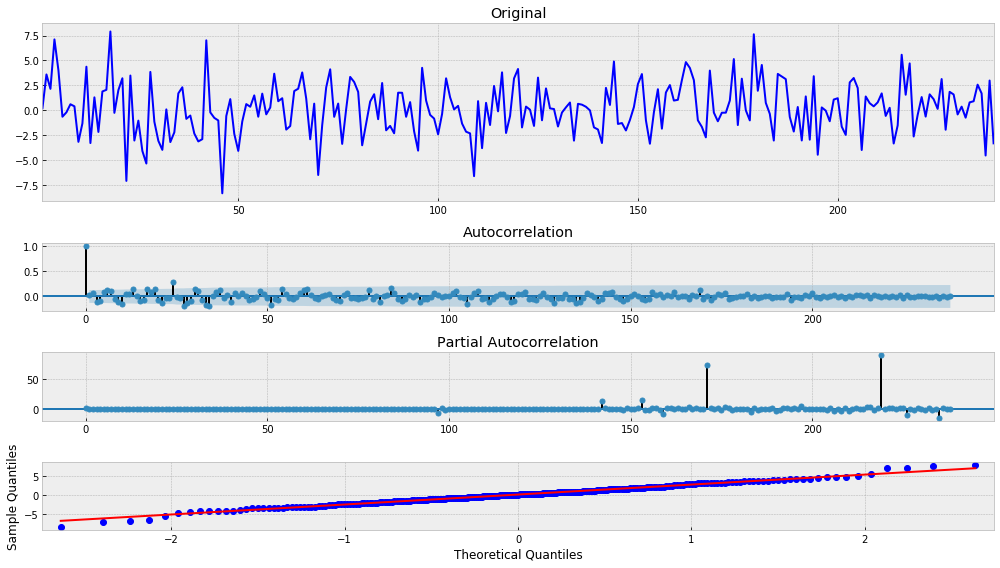

In [196]:
tsplot(mdl.resid)

остатки стационарны (говорят об этом тест Дики-Фуллера и p-значение), явных автокорреляций нет

найдем лучшие параметры для модели

In [243]:
# выравняем дисперсию и продифференцируем ряд
series = boxcox(series, 0)
series = series[24:] - series[:-24]

In [244]:
# применим к модели параметры, вычисленные по ARIMA
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT', vol='GARCH')
res = am.fit(update_freq=5)
res.summary()

Iteration:      5,   Func. Count:     71,   Neg. LLF: -290.22176140265486
Iteration:     10,   Func. Count:    131,   Neg. LLF: -291.94714104369194
Iteration:     15,   Func. Count:    191,   Neg. LLF: -292.0473390101401
Iteration:     20,   Func. Count:    251,   Neg. LLF: -292.05742350350135
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -292.0574350265797
            Iterations: 22
            Function evaluations: 275
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                292.057
Distribution:      Standardized Student's t   AIC:                          -564.115
Method:                  Maximum Likelihood   BIC:                          -530.362
                                              No. Observations:                  216
Date:                      Mon, Jul 22 2019   Df Residuals:                      206
Time:                              23:11:47   Df Model:                           10
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.2591e-04  6.815e-03 -6.250e-02      0.950 [-1.378e-02,1.293e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.2319e-03  1.023e-02      0.316      0.752 [-1.682e-02,2.328e-02]
alpha[1]       0.1739      0.396      0.440      0.660      [ -0.601,  0.949]
alpha[2]   3.3827e-11      0.804  4.207e-11      1.000      [ -1.576,  1.576]
gamma[1]       0.0707      0.564      0.125      0.900      [ -1.036,  1.177]
beta[1]        0.0000      2.729      0.000      1.000      [ -5.350,  5.350]
beta[2]        0.0000      0.906      0.000      1.000      [ -1.776,  1.776]
beta[3]        0.0000      0.754      0.000      1.000      [ -1.477,  1.477]
beta[4]        0.0000      0.548      0.000      1.000      [ -1.074,  1.074]
                               Distribution                               
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
nu            20.3814     51.685      0.394      0.693 [-80.919,1.217e+02]
==========================================================================

Covariance estimator: robust
"""

Results of Dickey-Fuller Test:
Test Statistic                -1.060178e+01
p-value                        6.144564e-19
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


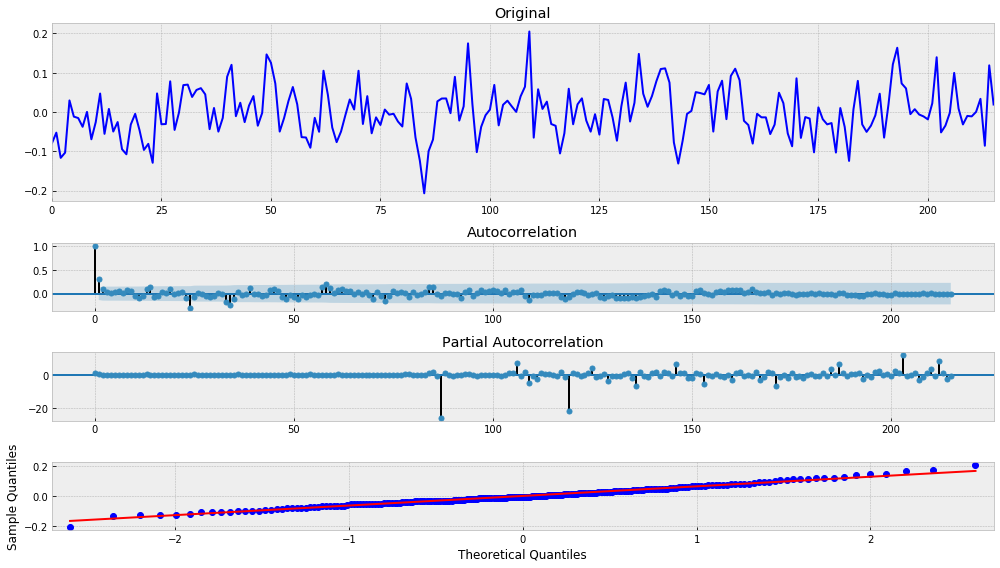

In [245]:
tsplot(res.resid)

получили стационарные остатки

# ML 

In [179]:
series=pd.read_csv("data/Series/mean-monthly-air-temperature-deg.csv")
series.head()

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [182]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

In [183]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

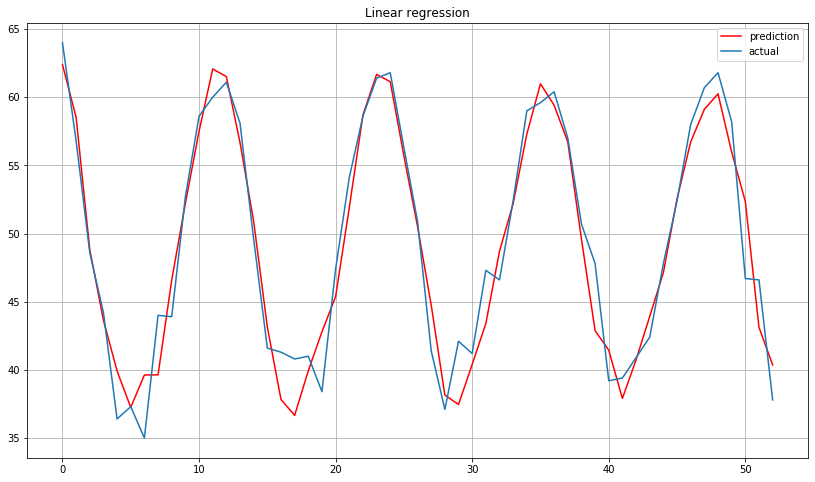

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [185]:
r2_score(y_pred=prediction, y_true=y_test.values)

0.9223020069855584